In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split

import string
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from scipy.stats import skew,boxcox  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from vecstack import stacking

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
pd.set_option('display.max_columns', 100)


# 1 Data Loading

In [29]:
raw_analysis = pd.read_csv('./analysisData.csv')
raw_scoring = pd.read_csv('./scoringData.csv')

def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_train = raw_analysis.copy()
df_test = raw_scoring.copy()
df_all = concat_df(df_train, df_test)

print('The shape of training set: {}'.format(df_train.shape))
print('The shape of test set: {}'.format(df_test.shape))
print('The shape of ALL set: {}'.format(df_all.shape))

The shape of training set: (36839, 91)
The shape of test set: (9210, 90)
The shape of ALL set: (46049, 91)


In [30]:
y = df_train.loc[:,['price']]

In [31]:
y.shape

(36839, 1)

# 2 Feature Selection 

In [32]:
columns_keep = [
                
                'accommodates','bathrooms','bedrooms','beds','bed_type',
                'cancellation_policy','cleaning_fee','extra_people','host_response_time',
                'host_has_profile_pic','guests_included',
                'review_scores_value', 'reviews_per_month', 'room_type','property_type',
                'security_deposit',
    
                'amenities', 'host_verifications','house_rules','interaction',
                'neighborhood_overview', 
                'summary','zipcode',
    
                'availability_30', 'availability_365','availability_60','availability_90',
                'calculated_host_listings_count', 'host_total_listings_count',
                'number_of_reviews','number_of_reviews_ltm'
               ]

X_all = df_all.loc[:, columns_keep]

In [33]:
type(X_all.amenities[123])

str

In [34]:

X_all.summary.isna().sum()

1768

# 3 Data Cleaning

In [35]:
X_all.beds = X_all.beds.fillna(X_all.beds.median())
X_all.reviews_per_month = X_all.reviews_per_month.fillna(X_all.reviews_per_month.median())

X_all['cleaning_fee_missing'] = X_all.cleaning_fee.isna()
X_all.cleaning_fee = X_all.cleaning_fee.fillna(X_all.cleaning_fee.median())

X_all.host_has_profile_pic = X_all.host_has_profile_pic.fillna(0)

X_all['security_deposit_missing']  = X_all.security_deposit.isna()
X_all.security_deposit = X_all.groupby(['beds','room_type'])['security_deposit'].apply(lambda x:x.fillna(x.median()))
X_all.security_deposit = X_all.security_deposit.fillna(X_all.security_deposit.median())

X_all['host_response_time_missing'] = X_all.host_response_time.isna()
X_all.host_response_time = X_all.host_response_time.fillna('missing')

X_all.host_total_listings_count = X_all.host_total_listings_count.fillna(X_all.host_total_listings_count.median())

X_all.house_rules = X_all.house_rules.fillna('missing')
X_all.interaction = X_all.interaction.fillna('missing')
X_all.neighborhood_overview = X_all.neighborhood_overview.fillna('missing')
X_all.number_of_reviews = X_all.number_of_reviews.fillna('missing')
X_all.summary = X_all.summary.fillna('missing')
X_all.amenities = X_all.amenities.fillna('missing')

In [36]:
def int_transform(x):
    try: 
        if type(x)==str:
            value = int(x[0:5])
        else:
            value = int(x)
    except:
        value = 0
    return value

X_all.zipcode = X_all.zipcode.apply(int_transform)
X_all['zipcode_missing'] = (X_all.zipcode==0)

In [37]:
X_all.isnull().sum().sum()

0

# 4 Feature Engineering

#### 4.1 Skewness 

In [38]:
# #continuous_features = ['cleaning_fee','reviews_per_month','security_deposit']
# numerical_features = [
#                         'extra_people','bathrooms','guests_included',
#                         'beds','accommodates','bedrooms','cleaning_fee',
#                         'reviews_per_month',
#                         'review_scores_value',
#                         'availability_30', 'availability_365','availability_60','availability_90',
#                         'calculated_host_listings_count', 'host_total_listings_count',
#                         'number_of_reviews','number_of_reviews_ltm'
#                      ]
# numerical_features
# skewness_features = X_all.loc[:,numerical_features].skew().sort_values(ascending=False)
# skewness_features


In [39]:
# from scipy.stats import boxcox
# for i in skewness_features.index:
#         df_tmp = X_all[i].apply(lambda x:x+0.00001)
#         try:
#             X_all[i],lmbda = boxcox(df_tmp,lmbda=None)
#         except:
#             print(i)

In [40]:
# skewness_features = X_all.loc[:,numerical_features].skew().sort_values(ascending=False)
# skewness_features

#### 4.2 Text Processing

In [41]:
test_features =['amenities', 'host_verifications','house_rules','interaction',
                'neighborhood_overview', 
                'summary'
               ]
for feat in test_features:
    X_all[feat] = X_all[feat].apply(lambda x: len(x))
X_all['summary'].head(10)

0    314
1    152
2    347
3    510
4     50
5    155
6    337
7    402
8    512
9    403
Name: summary, dtype: int64

#### 4.3 Label Encoding

In [42]:



cate_features = [
                 'bed_type','cancellation_policy','host_response_time',
                 'room_type', 'property_type', 'host_has_profile_pic','zipcode'
                ]
le = LabelEncoder()
for feat in cate_features:
    try:
        X_all[feat] = le.fit_transform(X_all[feat].astype(str))
    except: 
        print(feat)
    

In [43]:
X_all.sample(3)

,accommodates,bathrooms,bedrooms,beds,bed_type,cancellation_policy,cleaning_fee,extra_people,host_response_time,host_has_profile_pic,guests_included,review_scores_value,reviews_per_month,room_type,property_type,security_deposit,amenities,host_verifications,house_rules,interaction,neighborhood_overview,summary,zipcode,availability_30,availability_365,availability_60,availability_90,calculated_host_listings_count,host_total_listings_count,number_of_reviews,number_of_reviews_ltm,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing
34324,3,1.0,1,2.0,4,3,100.0,39,1,2,1,9,0.81,1,23,100.0,357,36,56,223,415,321,122,30,180,60,90,3,3.0,17,6,False,False,True,False
20943,2,1.0,1,1.0,4,0,15.0,0,1,2,2,10,0.13,1,1,100.0,186,29,522,7,7,326,28,0,0,0,0,1,1.0,4,0,False,True,True,False
22198,4,1.0,2,2.0,4,0,25.0,25,4,2,2,9,0.13,0,1,150.0,297,41,367,35,305,483,38,0,0,0,0,1,1.0,2,0,False,False,False,False


#### 4.4 OneHot and Not OneHot

In [44]:
X_all1 = X_all.copy()
X_all2 = X_all.copy()

onehot_features = [
                    'bed_type', 'cancellation_policy','host_response_time',
                    'room_type', 'property_type',
                    'host_has_profile_pic','zipcode'
                  ]

for feat in onehot_features:
    dummy_col = pd.get_dummies(X_all1[feat], prefix=feat)
    X_all1 = pd.concat([X_all1, dummy_col],axis=1)

X_all1 = X_all1.drop(onehot_features, axis=1)

In [45]:
X_all1.sample(3)

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,extra_people,guests_included,review_scores_value,reviews_per_month,security_deposit,amenities,host_verifications,house_rules,interaction,neighborhood_overview,summary,availability_30,availability_365,availability_60,availability_90,calculated_host_listings_count,host_total_listings_count,number_of_reviews,number_of_reviews_ltm,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing,bed_type_0,bed_type_1,bed_type_2,bed_type_3,bed_type_4,cancellation_policy_0,cancellation_policy_1,cancellation_policy_2,cancellation_policy_3,cancellation_policy_4,cancellation_policy_5,host_response_time_0,host_response_time_1,host_response_time_2,host_response_time_3,host_response_time_4,room_type_0,room_type_1,room_type_2,property_type_0,property_type_1,property_type_2,...,zipcode_145,zipcode_146,zipcode_147,zipcode_148,zipcode_149,zipcode_150,zipcode_151,zipcode_152,zipcode_153,zipcode_154,zipcode_155,zipcode_156,zipcode_157,zipcode_158,zipcode_159,zipcode_160,zipcode_161,zipcode_162,zipcode_163,zipcode_164,zipcode_165,zipcode_166,zipcode_167,zipcode_168,zipcode_169,zipcode_170,zipcode_171,zipcode_172,zipcode_173,zipcode_174,zipcode_175,zipcode_176,zipcode_177,zipcode_178,zipcode_179,zipcode_180,zipcode_181,zipcode_182,zipcode_183,zipcode_184,zipcode_185,zipcode_186,zipcode_187,zipcode_188,zipcode_189,zipcode_190,zipcode_191,zipcode_192,zipcode_193,zipcode_194
36752,4,1.0,1,2.0,80.0,30,2,10,1.00,200.0,83,89,7,7,7,7,11,15,15,15,1,1.0,1,1,False,True,False,False,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37161,1,1.0,1,1.0,75.0,75,1,10,0.18,0.0,318,92,319,84,246,217,0,208,17,47,3,3.0,11,0,False,False,False,False,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27610,4,1.5,1,2.0,25.0,20,2,10,2.00,0.0,86,89,21,31,22,148,16,69,46,69,7,2.0,2,2,False,False,False,False,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
# make sure features name unique
X_all2.sample(3)

,accommodates,bathrooms,bedrooms,beds,bed_type,cancellation_policy,cleaning_fee,extra_people,host_response_time,host_has_profile_pic,guests_included,review_scores_value,reviews_per_month,room_type,property_type,security_deposit,amenities,host_verifications,house_rules,interaction,neighborhood_overview,summary,zipcode,availability_30,availability_365,availability_60,availability_90,calculated_host_listings_count,host_total_listings_count,number_of_reviews,number_of_reviews_ltm,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing
35813,6,2.5,2,3.0,4,3,250.0,0,2,2,1,10,0.04,0,1,200.0,394,55,7,7,355,360,11,0,315,10,40,1,2.0,1,0,False,True,False,False
2273,1,1.0,1,1.0,4,3,0.0,0,1,2,1,10,0.08,1,20,300.0,349,48,346,151,554,513,163,0,0,0,0,2,2.0,1,0,False,False,True,False
42983,4,1.0,0,2.0,4,3,15.0,0,1,2,1,10,0.74,0,1,0.0,401,98,15,147,18,257,23,29,179,59,89,2,2.0,6,6,False,False,True,False


#### 4.5 Max-min Scaling

In [47]:
# scaler = MinMaxScaler(feature_range=(0,1))
# X_all1 = pd.DataFrame(data = scaler.fit_transform(X_all1),
#                       columns = X_all1.columns)
# X_all2 = pd.DataFrame(data = scaler.fit_transform(X_all2),
#                       columns = X_all2.columns)
# X_all1.sample(3)

In [48]:
X_all2.sample(3)

,accommodates,bathrooms,bedrooms,beds,bed_type,cancellation_policy,cleaning_fee,extra_people,host_response_time,host_has_profile_pic,guests_included,review_scores_value,reviews_per_month,room_type,property_type,security_deposit,amenities,host_verifications,house_rules,interaction,neighborhood_overview,summary,zipcode,availability_30,availability_365,availability_60,availability_90,calculated_host_listings_count,host_total_listings_count,number_of_reviews,number_of_reviews_ltm,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing
12241,3,1.0,1,1.0,4,1,50.0,0,3,2,1,9,0.50,0,1,100.0,265,29,29,7,7,425,95,0,0,0,0,1,2.0,15,6,False,False,False,False
44704,2,1.0,0,0.0,4,3,75.0,10,1,2,2,10,0.82,0,11,675.0,592,69,691,7,760,350,95,0,208,1,26,1,1.0,27,10,False,False,True,False
32088,5,1.0,1,3.0,4,3,130.0,0,1,2,1,10,0.33,0,28,0.0,646,36,7,7,7,505,12,0,8,0,0,11,11.0,4,4,False,False,True,False


In [49]:
print(X_all2.shape)

(46049, 35)


# 5 X, X_test split
##### Now:  X_all -> X + X_test 
##### Later:......... -> (X_train+X_dev) + X_test

In [50]:
X1, X_test1 = X_all1.iloc[0:36839], X_all1.iloc[36839:] 
X2, X_test2 = X_all2.iloc[0:36839], X_all2.iloc[36839:]
print(X1.shape)
print(X_test1.shape)
print(X2.shape)
print(X_test2.shape)

(36839, 279)
(9210, 279)
(36839, 35)
(9210, 35)


In [51]:
X1.head()

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,extra_people,guests_included,review_scores_value,reviews_per_month,security_deposit,amenities,host_verifications,house_rules,interaction,neighborhood_overview,summary,availability_30,availability_365,availability_60,availability_90,calculated_host_listings_count,host_total_listings_count,number_of_reviews,number_of_reviews_ltm,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing,bed_type_0,bed_type_1,bed_type_2,bed_type_3,bed_type_4,cancellation_policy_0,cancellation_policy_1,cancellation_policy_2,cancellation_policy_3,cancellation_policy_4,cancellation_policy_5,host_response_time_0,host_response_time_1,host_response_time_2,host_response_time_3,host_response_time_4,room_type_0,room_type_1,room_type_2,property_type_0,property_type_1,property_type_2,...,zipcode_145,zipcode_146,zipcode_147,zipcode_148,zipcode_149,zipcode_150,zipcode_151,zipcode_152,zipcode_153,zipcode_154,zipcode_155,zipcode_156,zipcode_157,zipcode_158,zipcode_159,zipcode_160,zipcode_161,zipcode_162,zipcode_163,zipcode_164,zipcode_165,zipcode_166,zipcode_167,zipcode_168,zipcode_169,zipcode_170,zipcode_171,zipcode_172,zipcode_173,zipcode_174,zipcode_175,zipcode_176,zipcode_177,zipcode_178,zipcode_179,zipcode_180,zipcode_181,zipcode_182,zipcode_183,zipcode_184,zipcode_185,zipcode_186,zipcode_187,zipcode_188,zipcode_189,zipcode_190,zipcode_191,zipcode_192,zipcode_193,zipcode_194
0,2,1.5,1,1.0,0.0,0,1,10,1.88,0.0,169,89,7,36,35,314,10,10,10,10,1,1.0,3,3,False,False,True,False,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1.0,2,2.0,10.0,20,1,9,0.21,100.0,268,29,7,38,93,152,20,59,29,59,2,2.0,8,6,False,False,False,False,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1.0,1,1.0,50.0,0,1,9,0.36,100.0,119,55,7,50,7,347,0,0,0,0,1,1.0,5,1,True,True,True,False,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1.0,1,1.0,0.0,20,1,9,9.69,0.0,362,60,7,344,353,510,23,358,53,83,1,1.0,31,31,False,False,False,False,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,1.0,1,1.0,10.0,18,1,9,2.62,0.0,313,92,1024,194,7,50,20,70,40,70,1,2.0,57,27,False,False,False,False,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


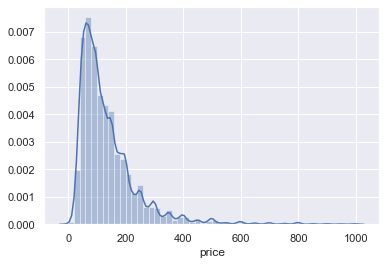

In [52]:
sns.distplot(y.price)

In [53]:
filter = (X1.bathrooms < 5) & (X1.bedrooms <= 7) & (X1.amenities <= 1000) & (y.price < 400)
X1_filtered = X1[filter]
X1_filtered.shape

(35610, 279)

In [54]:
y[filter].shape

(35610, 1)

# 6 Model Selection
##### train X_train, predict X_dev

#### 6.1 Basic GSCV setting

In [55]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=25)
param_GB = {'min_samples_leaf': [1,2,5,10,20],
            'max_depth': [3,4,5],
            'max_features': ['sqrt'],
            'learning_rate': [0.001,0.05,0.1,1],
            'criterion': ['mse'],
            'n_estimators': [100,500]
           }
GSCV = GridSearchCV(
                  GradientBoostingRegressor(),
                  param_grid = param_GB,
                  cv = kfolds,
                  scoring = 'neg_mean_squared_error',
                  n_jobs = -1
                 )


param_LGBM = {'n_estimators':[800],
              'num_leaves':[37],
              'max_depth': [6,9],
              'learning_rate': [0.05],
              'reg_alpha':[3,15,30]
             } # 60min

LGBM = GridSearchCV(
                  LGBMRegressor(objective='regression'),
                  param_grid = param_LGBM,
                  cv = kfolds,
                  scoring = 'neg_mean_squared_error',
                  n_jobs = -1
                 )

# LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
#               importance_type='split', learning_rate=0.05, max_depth=11,
#               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#               n_estimators=1000, n_jobs=-1, num_leaves=37,
#               objective='regression', random_state=None, reg_alpha=15,
#               reg_lambda=0.0, silent=True, subsample=1.0,
#               subsample_for_bin=200000, subsample_freq=0)
e_alphas = [1e-6,1e-5,1e-3,0.1,1,10,100] # 1:30
e_l1ratio = [0.01,0.1,0.4,0.6,0.9,0.99]
elasticnet = ElasticNetCV(
                          max_iter = 1e7, 
                          alphas = e_alphas,
                          cv=kfolds, 
                          l1_ratio=e_l1ratio
                         )

In [56]:
kfolds

KFold(n_splits=5, random_state=25, shuffle=True)

#### 6.2 Global CV for X_train X_dev split

In [57]:
# M = []
# X_area = X1_area
X = X1[-filter]
X_test = X_test1

# LR = elasticnet.fit(X,y[filter]).best_estimator_
# sqrt(-elasticnet.best_score_)

# LR = elasticnet.fit(X,y[filter]).best_estimator_
# sqrt(-elasticnet.best_score_)


M_all = LGBM.fit(X,y[-filter]).best_estimator_
sqrt(-LGBM.best_score_)



138.43495080721195

In [58]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=25)
M = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                  importance_type='split', learning_rate=0.05, max_depth=11,
                  min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                  n_estimators=1000, n_jobs=-1, num_leaves=37,
                  objective='regression', random_state=None, reg_alpha=15,
                  reg_lambda=0.0, silent=True, subsample=1.0,
                  subsample_for_bin=200000, subsample_freq=0)

cv_nmse = cross_val_score(M, X1[filter], y[filter], scoring='neg_mean_squared_error',cv=5)
print('cv score: ', sqrt(-np.mean(cv_nmse)))


M.fit(X1[filter],y[filter])
print('train score: ',sqrt(mean_squared_error(M.predict(X1[filter]), y[filter])) )
print('test score: ',sqrt(mean_squared_error(M.predict(X1[-filter]), y[-filter])) )

cv score:  41.60926869204368
train score:  30.054384867243485
test score:  302.5216130199554


In [277]:
kfolds = KFold(n_splits=30, shuffle=True, random_state=135)
cvscore = cross_val_score(LGB,X, y, scoring='neg_mean_squared_error',cv=kfolds)
print(cvscore)
print(np.mean(cvscore))

[-3456.26254668 -3758.10107468 -2844.11755075 -3696.10644255
 -3255.13385952 -3172.04657684 -2869.09053429 -3969.04372202
 -3205.73521642 -2563.5418833  -3304.06676146 -3767.90240582
 -3420.16530367 -3808.57574071 -3044.555656   -3422.38668461
 -3703.98453609 -3405.81235064 -3547.76250579 -5281.59637393
 -2985.85994159 -3726.82886889 -3256.13824664 -3723.96671232
 -2856.76809503 -3607.40544956 -3770.18268267 -3301.74518097
 -3193.53121328 -2960.97497659]
-3429.3129697759296


In [128]:
GB = GSCV.best_estimator_

In [ ]:
y_final = M_all.predict(X_test)

In [83]:
# enable = [True for i in range(60)]

In [104]:
# y_pred_groupfit = []
# y_pred_all = []

# for row in range(0,36389):
    
#     nbg = df_train.get_value(row,'neighbourhood_cleansed')
#     p1 = M_all.predict(X.iloc[[row]])
    
#     if not (nbg in nbg_list):
#         y_pred_groupfit.append(p1)
#     else:
#         i = nbg_list.index(nbg)
#         p2 = M[i].predict(X.iloc[[row]])
#         y_pred_groupfit.append(p2)
#         p_real = y.get_value(row,'price')
#         if abs(p_real-p1) < abs(p_real-p2):
#             enable[i] = False # groupfit play worse than allfit
            
#     y_pred_all.append(p1)




In [ ]:
# y_final = []
# for row in range(0,9210):
#     nbg = df_train.get_value(row+36389,'neighbourhood_cleansed')
#     if nbg not in nbg_list:
#         y_final.append(M_all.predict(X_test.iloc[[row]]))
#     else:
#         i = nbg_list.index(nbg)
        
#         if enable[i] == True:
#             y_final.append(M[i].predict(X_test.iloc[[row]]))
#         else:
#             y_final.append(M_all.predict(X_test.iloc[[row]]))
# y_final

# 7 Final Prediction and Submit 
##### train X, predict X_test 

In [34]:
X = X2
X_test = X_test2

M1 = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                   importance_type='split', learning_rate=0.01, max_depth=-1,
                   min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                   n_estimators=10000, n_jobs=-1, num_leaves=31,
                   objective='regression', random_state=None, reg_alpha=0.0,
                   reg_lambda=0.0, silent=True, subsample=1.0,
                   subsample_for_bin=200000, subsample_freq=0)
M2 = GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=20, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
M3 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=8000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
param_Stack = {'hidden_layer_sizes':[(3,),(2,),(2,2)],
               'learning_rate_init':[0.0001,0.001,0.01,0.1,0.3,0.5,0.9]
              } # 6 min
Stack = GridSearchCV(
                      MLPRegressor(),
                      param_grid = param_Stack,
                      cv = 5,
                      n_jobs = -1
                     )
Models = [M1,M2,M3]

y_Predict = []
y_test_Predict = []

for i in range(len(Models)):
        print(datetime.now())
        Models[i].fit(X, y)
        print(datetime.now(),'Predicting Models ')
        y_Predict.append(Models[i].predict(X).reshape(1,len(X))[0])
        y_test_Predict.append(Models[i].predict(X_test).reshape(1,len(X_test))[0])
        print('Model has training rmse = ',sqrt(mean_squared_error(y_Predict[i], y)))



S = np.transpose(y_Predict)
S_test = np.transpose(y_test_Predict)
Stack.fit(S, y)
print('Stack Model has training rmse = ',sqrt(mean_squared_error(Stack.predict(S), y)))
y_final = Stack.predict(S_test) #.reshape(1,len(X_test))[0])


2019-11-17 10:49:53.194203
2019-11-17 10:50:28.802841 Predicting Models 
Model has training rmse =  37.83512350212674
2019-11-17 10:51:43.389652


KeyboardInterrupt: 

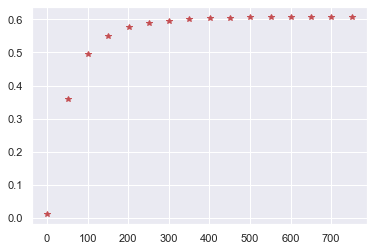

In [61]:
M1 = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                   importance_type='split', learning_rate=0.01, max_depth=-1,
                   min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                   n_estimators=700, n_jobs=-1, num_leaves=31,
                   objective='regression', random_state=None, reg_alpha=0.0,
                   reg_lambda=0.0, silent=True, subsample=1.0,
                   subsample_for_bin=20000, subsample_freq=0)
M3 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
score = []
for i in range(1,800,50):
    M1 = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                   importance_type='split', learning_rate=0.01, max_depth=-1,
                   min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
                   n_estimators=i, n_jobs=-1, num_leaves=40,
                   objective='regression', random_state=None, reg_alpha=0.0,
                   reg_lambda=0.0, silent=True, subsample=1.0,
                   subsample_for_bin=15, subsample_freq=0)
    score.append(np.mean(cross_val_score(M1,X,y,cv=3)))
plt.plot(range(1,800,50),score, 'r*')

In [114]:
# BESTMODEL.fit(X_BEST)
# y_final = BESTMODEL.predict(X_BEST)

result_df = pd.DataFrame(columns=['id','price'])
result_df['id'] = df_test.id
result_df['price'] = y_final
result_df = result_df.astype(int)
result_df.to_csv('submissions.csv', index=False)
result_df

,id,price
0,23136,118
1,37597,92
2,38982,159
3,42288,73
4,45375,76
5,47609,167
6,48740,91
7,48850,141
8,49205,104
9,49786,175
